## Topic Modeling LSA/I, probabilistic LSA / NMF and LDA

### Imports

In [1]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

c:\users\rujjn\anaconda3\envs\spacy\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\rujjn\anaconda3\envs\spacy\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
docs = pd.read_pickle('training_set.pkl')

topic_dict = {'topic':{1: 'computers', 2: 'censorship', 3: 'cyclist', 4: 'hibiscus', 5: 'mood', 6: 'dirigibles', 7: 'patience', 8: 'laughter'}}

docs.replace(topic_dict, inplace=True)

docs.sample(10)

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,char_len,word_count,tokens,lemma,pos
7410,12158,mood,The author creates a mood that he is very grea...,3,2,nan,3,nan,nan,nan,...,nan,nan,nan,nan,nan,715,134,"[The, author, creates, a, mood, that, he, is, ...","[the, author, create, a, mood, that, -PRON-, b...","[DET, NOUN, VERB, DET, NOUN, ADJ, PRON, VERB, ..."
12200,19506,patience,Sometimes on days when I have @CAPS1 patience ...,12,8,nan,20,nan,nan,nan,...,nan,nan,nan,nan,nan,1195,242,"[Sometimes, on, days, when, I, have, @CAPS1, p...","[sometimes, on, day, when, -PRON-, have, @caps...","[ADV, ADP, NOUN, ADV, PRON, VERB, ADJ, NOUN, A..."
2634,3829,censorship,There is much censorship that occurs in the wo...,3,4,nan,3,3.00,3.00,3.00,...,nan,nan,nan,nan,nan,2039,358,"[There, is, much, censorship, that, occurs, in...","[there, be, much, censorship, that, occur, in,...","[ADV, VERB, ADJ, NOUN, ADJ, VERB, ADP, DET, NO..."
5949,9505,hibiscus,The author of this story concludes it with thi...,1,2,nan,2,nan,nan,nan,...,nan,nan,nan,nan,nan,640,132,"[The, author, of, this, story, concludes, it, ...","[the, author, of, this, story, conclude, -PRON...","[DET, NOUN, ADP, DET, NOUN, VERB, PRON, ADP, D..."
2933,4128,censorship,Have you ever came across offensive material i...,4,4,nan,4,4.00,4.00,4.00,...,nan,nan,nan,nan,nan,2669,492,"[Have, you, ever, came, across, offensive, mat...","[have, -PRON-, ever, come, across, offensive, ...","[VERB, PRON, ADV, VERB, ADP, ADJ, NOUN, ADP, D..."
11773,19039,patience,Topic: write a story in your own way about pat...,9,9,nan,18,nan,nan,nan,...,nan,nan,nan,nan,nan,916,174,"[Topic, :, write, a, story, in, your, own, way...","[topic, :, write, a, story, in, -PRON-, own, w...","[NOUN, PUNCT, VERB, DET, NOUN, ADP, ADJ, ADJ, ..."
6555,10112,hibiscus,The author concludes the end of this story wit...,1,1,nan,1,nan,nan,nan,...,nan,nan,nan,nan,nan,376,75,"[The, author, concludes, the, end, of, this, s...","[the, author, conclude, the, end, of, this, st...","[DET, NOUN, VERB, DET, NOUN, ADP, DET, NOUN, A..."
7318,12066,mood,The mood by the author in the memories.,0,0,nan,0,nan,nan,nan,...,nan,nan,nan,nan,nan,39,9,"[The, mood, by, the, author, in, the, memories...","[the, mood, by, the, author, in, the, memory, .]","[DET, NOUN, ADP, DET, NOUN, ADP, DET, NOUN, PU..."
3791,6187,cyclist,The features of the setting affected the cycli...,1,1,nan,1,nan,nan,nan,...,nan,nan,nan,nan,nan,198,41,"[The, features, of, the, setting, affected, th...","[the, feature, of, the, setting, affect, the, ...","[DET, NOUN, ADP, DET, NOUN, VERB, DET, NOUN, A..."
3371,4566,censorship,REMOVING BOOKS FROM THE LIBRARY BECAUSE THEY A...,3,3,nan,3,3.00,2.00,3.00,...,nan,nan,nan,nan,nan,1880,346,"[REMOVING, BOOKS, FROM, THE, LIBRARY, BECAUSE,...","[remove, book, from, the, library, because, th...","[VERB, NOUN, ADP, DET, NOUN, ADP, PRON, VERB, ..."


In [4]:
# word count
docs.essay.str.split().str.len().sum()

2889861

In [5]:
docs.topic.value_counts(normalize=True)

mood         0.14
censorship   0.14
dirigibles   0.14
computers    0.14
hibiscus     0.14
cyclist      0.13
patience     0.12
laughter     0.06
Name: topic, dtype: float64

## Prepare Document-Term Matrix

### Baseline document-term matrix

In [6]:
# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.essay)
doc_term_matrix

<12976x38218 sparse matrix of type '<class 'numpy.int64'>'
	with 1395523 stored elements in Compressed Sparse Row format>

### Inspect tokens

In [7]:
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

['00', '000', '00pm', '046', '101st', '102', '102nd', '10535', '10536', '11']

### Inspect doc-term matrix

In [8]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,00pm,046,101st,102,102nd,10535,10536,11,...,zone,zoned,zoning,zoo,zoom,zoomed,zooming,zoos,zzz,â½
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Most frequent terms

In [9]:
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head() 

the     151582
to       98860
and      79657
of       53458
that     51111
dtype: int32

### Compute relative term frequency

In [10]:
vectorizer = CountVectorizer(binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.essay)
doc_term_matrix.shape

(12976, 38218)

In [11]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(
    docs.shape[0]).sort_values(ascending=False).head(10)

the    0.99
to     0.94
and    0.92
in     0.86
of     0.85
that   0.84
it     0.76
is     0.76
for    0.68
was    0.62
dtype: float64

### Visualize Doc-Term Matrix

In [12]:
# sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
# plt.gcf().set_size_inches(14, 8);

### Using thresholds to reduce the number of tokens 

In [13]:
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs.essay)
doc_term_matrix.shape

(12976, 12139)

### Use CountVectorizer with Lemmatization

#### Building a custom `tokenizer` for Lemmatization with `spacy`

In [14]:
nlp = spacy.load('en_core_web_sm')
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc) 
                if not w.is_punct | w.is_space]

In [15]:
vectorizer = CountVectorizer(tokenizer=tokenizer, binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.essay)
doc_term_matrix.shape

(12976, 37247)

In [16]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=lemmatized_words).div(docs.shape[0])
word_freq_1d.sort_values().tail(20)

when      0.48
there     0.48
do        0.57
because   0.58
i         0.58
this      0.59
on        0.59
with      0.59
not       0.62
for       0.68
have      0.76
that      0.84
of        0.85
in        0.86
a         0.87
and       0.92
to        0.94
be        0.98
-PRON-    0.98
the       0.99
dtype: float64

Unlike verbs and common nouns, there's no clear base form of a personal pronoun. Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.

### TfIdf Vectorizer 

In [17]:
tfidf = TfidfVectorizer()
doc_term_matrix = tfidf.fit_transform(docs.essay)
doc_term_matrix.shape

(12976, 38218)

In [18]:
words = tfidf.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=words)
word_freq_1d.sort_values().tail(20) 

are        410.95
this       417.84
my         430.98
people     434.43
on         444.73
for        456.29
be         468.68
they       510.95
she        513.17
he         599.52
you        674.42
it         679.07
is         683.23
was        695.24
in         713.55
that       787.35
of         836.71
and      1,116.84
to       1,367.42
the      2,340.33
dtype: float64

## Create Train & Test Sets

In [19]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=100, 
                                         random_state=42)

In [20]:
train_docs.shape, test_docs.shape

((12876, 33), (100, 33))

In [21]:
pd.Series(test_docs.topic).value_counts()

mood          14
hibiscus      14
censorship    14
computers     14
dirigibles    14
cyclist       13
patience      12
laughter       5
Name: topic, dtype: int64

### Vectorize train & test sets

In [22]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.essay)
words = vectorizer.get_feature_names()
train_dtm

<12876x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 603221 stored elements in Compressed Sparse Row format>

In [23]:
test_dtm = vectorizer.transform(test_docs.essay)
test_dtm

<100x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4404 stored elements in Compressed Sparse Row format>

## Latent Semantic Analysis

In [24]:
svd = TruncatedSVD(n_components=8, n_iter=20, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(algorithm='randomized', n_components=8, n_iter=20,
       random_state=42, tol=0.0)

### Explore Topics 

In [25]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 9)]

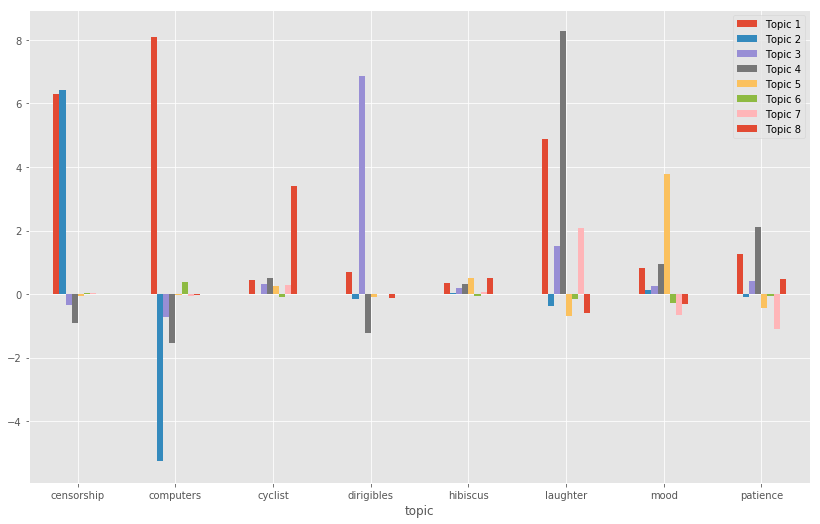

In [26]:
svd_result = pd.DataFrame(data=svd.transform(train_dtm),
                   columns=topic_labels,
                   index=train_docs.topic)
svd_result.groupby(level='topic').mean().plot.bar(rot=0);

In [27]:
topics = pd.DataFrame(svd.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
1937,0.00,-0.00,0.01,-0.00,-0.00,0.00,-0.00,-0.00
250,0.00,-0.00,0.01,-0.00,-0.00,-0.00,0.00,-0.00
abandoned,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.03
abhor,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
ability,0.02,-0.01,-0.00,-0.01,-0.00,-0.02,0.01,0.00


In [28]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,computers,books,building,laughter,parents,computer,laughter,cyclist
1,computer,book,dirigibles,person1,mood,spend,laugh,water
2,books,offensive,state,laugh,memoir,friends,laughing,setting
3,book,read,empire,caps3,narciso,don,friends,features
4,offensive,library,mast,said,love,kids,person,road
5,friends,libraries,builders,laughing,grateful,outside,relationship,affect
6,read,movies,mooring,got,rodriguez,day,funny,affected
7,don,music,dirigible,caps4,paragraph,nature,really,hot
8,library,children,faced,day,created,bad,makes,hills
9,caps3,magazines,obstacles,caps5,happy,exercise,feel,rough


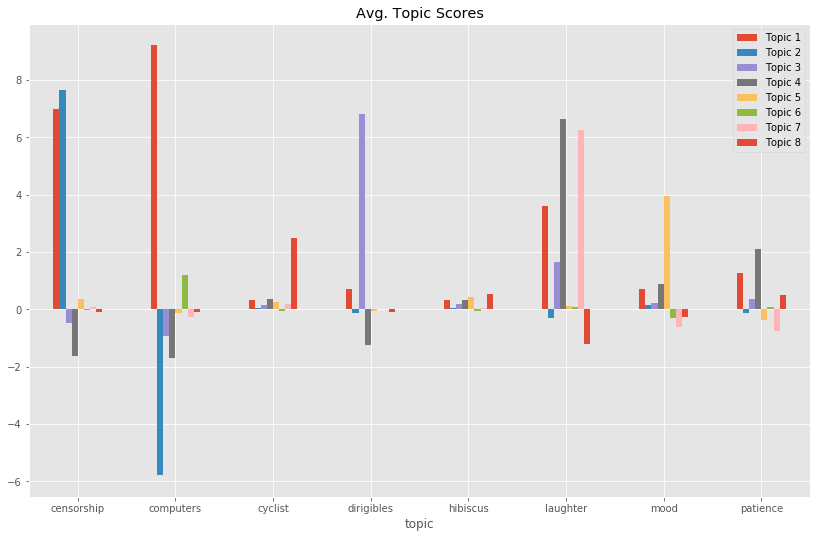

In [29]:
test_eval = pd.DataFrame(data=svd.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Scores', rot=0);

## probabilistic Latent Semantic Analysis

### Implementation using Non-Negative Matrix Factorization

pLSI [has been shown](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.8839&rep=rep1&type=pdf) to be equivalent to Non-Negative Matrix Factorization with Kullback-Leibler Divergence objective.

In [30]:
nmf = NMF(n_components=8, random_state=42, solver='mu',
          beta_loss='kullback-leibler', max_iter=1000)
nmf.fit(train_dtm)
nmf.reconstruction_err_

1949.9352327663269

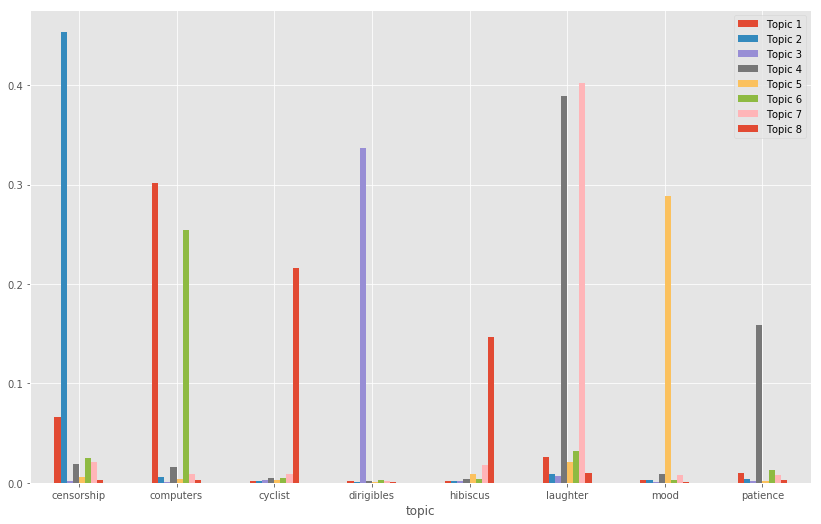

In [31]:
nmf_res = pd.DataFrame(data=nmf.transform(train_dtm),
                       columns=topic_labels,
                       index=train_docs.topic)
nmf_res.groupby(level='topic').mean().plot.bar(rot=0);

In [32]:
topics = pd.DataFrame(nmf.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
1937,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00
250,0.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00
abandoned,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.29
abhor,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00
ability,0.56,0.00,0.00,0.00,0.00,0.00,0.08,0.06


In [33]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,computers,books,building,got,mood,computer,laughter,cyclist
1,computer,book,dirigibles,patient,parents,friends,laugh,saeng
2,use,offensive,state,said,memoir,don,laughing,water
3,help,read,empire,person1,narciso,kids,friends,test
4,need,library,mast,caps3,love,spend,really,setting
5,learn,libraries,builders,went,happy,bad,feel,hibiscus
6,talk,movies,mooring,caps4,created,outside,day,paragraph
7,world,music,dirigible,mom,grateful,day,thing,features
8,friends,children,obstacles,day,rodriguez,nature,best,spring
9,caps3,magazines,faced,didn,house,play,person,concludes


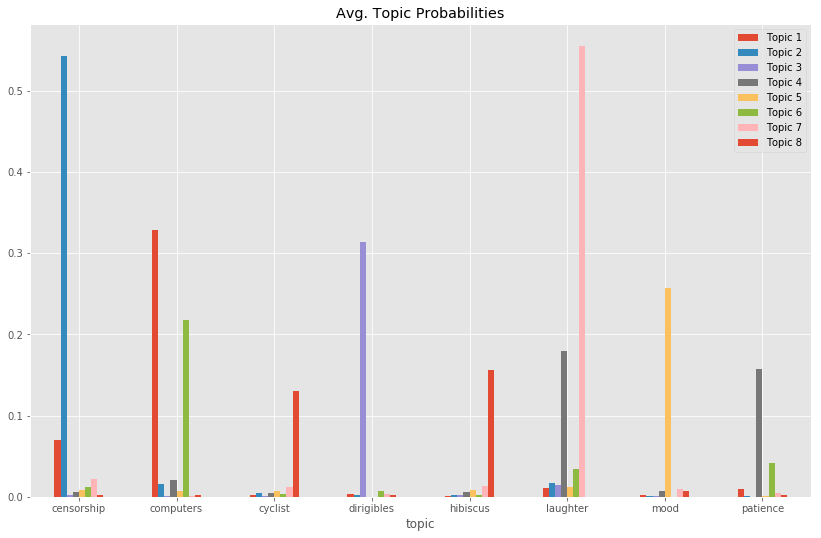

In [34]:
test_eval = pd.DataFrame(data=nmf.transform(test_dtm),
                         columns=topic_labels,
                         index=test_docs.topic)

test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities', rot=0);

## Latent Dirichlet Allocation

### Simulate Dirichlet Distribution

In [35]:
f=FloatSlider(value=1, min=1e-2, max=1e2, step=1e-2, continuous_update=False, description='Alpha')
@interact(alpha=f)
def sample_dirichlet(alpha):
    topics = 8
    draws= 6
    alphas = np.full(shape=topics, fill_value=alpha)
    samples = np.random.dirichlet(alpha=alphas, size=draws)
    
    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
    axes = axes.flatten()
    plt.setp(axes, ylim=(0, 1))
    for i, sample in enumerate(samples):
        axes[i].bar(x=list(range(8)), height=sample, color=sns.color_palette("Set2", 8))
    fig.suptitle('Dirichlet Allocation | 8 Topics, 6 Samples')
    fig.tight_layout()
    plt.subplots_adjust(top=.95)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Alpha', min=0.01, step=0.01…

### LDA with sklearn

In [36]:
lda_base = LatentDirichletAllocation(n_components=8,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=8, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

#### Persist model

In [37]:
joblib.dump(lda_base, 'lda_10_iter.pkl')

['lda_10_iter.pkl']

In [38]:
lda_base = joblib.load('lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=8, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Explore topics & word distributions

In [39]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(8, 2000)


array([[ 0.12500084,  0.12500098,  0.12500175, ...,  0.12500759,
         0.12501082,  0.12500258],
       [90.12499478, 71.12499351,  7.54432887, ...,  0.1250014 ,
         0.12500116,  0.12500061],
       [ 0.12500035,  0.12500033,  0.12500858, ...,  0.91340384,
         0.23814457,  0.12500205],
       [ 0.12500225,  0.12500153,  0.1250137 , ...,  8.37539956,
         0.12516693,  0.12512784],
       [ 0.12500022,  0.12500129,  0.12504781, ..., 32.89688939,
        14.4116084 , 76.72146719]])

In [40]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
1937,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
250,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
abandoned,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
abhor,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ability,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [41]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

In [42]:
topics.shape

(2000, 8)

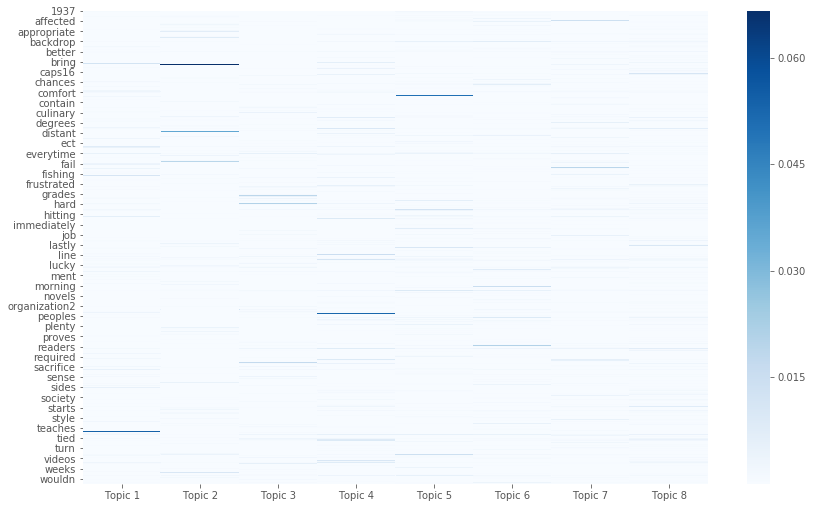

In [43]:
sns.heatmap(topics, cmap='Blues');

In [44]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,saeng,building,mood,patient,computers,books,cyclist,caps3
1,test,dirigibles,parents,got,computer,book,water,person1
2,hibiscus,state,memoir,mom,friends,offensive,setting,caps4
3,paragraph,empire,narciso,patience,use,read,features,laughter
4,spring,mast,love,wait,help,library,road,laugh
5,concludes,builders,happy,went,talk,libraries,affect,day
6,geese,mooring,created,said,learn,movies,affected,caps5
7,winter,dirigible,grateful,waiting,online,music,hot,laughing
8,plant,faced,rodriguez,line,need,children,hills,said
9,budding,obstacles,house,dad,don,magazines,desert,caps6


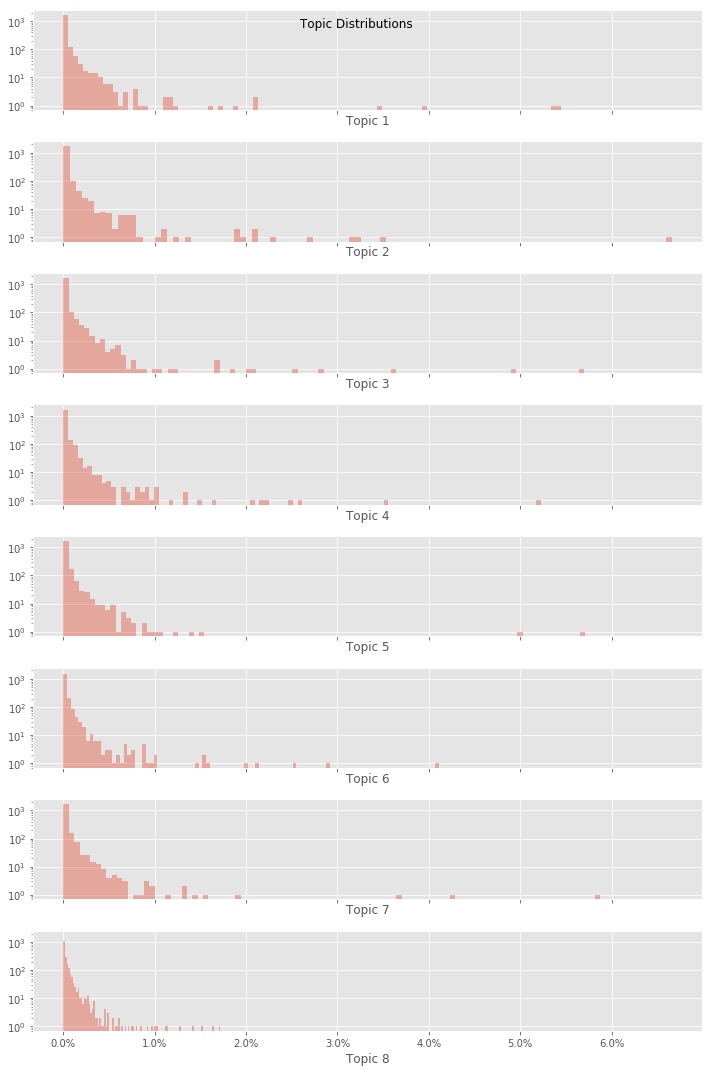

In [45]:
fig, axes = plt.subplots(nrows=8, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

### Evaluate Fit on Train Set

In [46]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(12876, 8)

In [47]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
topic,,,,,,,,
mood,0.00,0.00,0.91,0.00,0.00,0.00,0.00,0.08
dirigibles,0.00,0.80,0.00,0.09,0.10,0.00,0.00,0.00
dirigibles,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00
dirigibles,0.02,0.97,0.00,0.00,0.00,0.00,0.00,0.00
mood,0.01,0.01,0.69,0.01,0.27,0.01,0.01,0.01
computers,0.00,0.00,0.00,0.00,0.96,0.04,0.00,0.00
censorship,0.00,0.00,0.00,0.00,0.00,0.99,0.00,0.00
dirigibles,0.05,0.94,0.00,0.00,0.00,0.00,0.00,0.00
mood,0.06,0.01,0.90,0.01,0.01,0.01,0.01,0.01


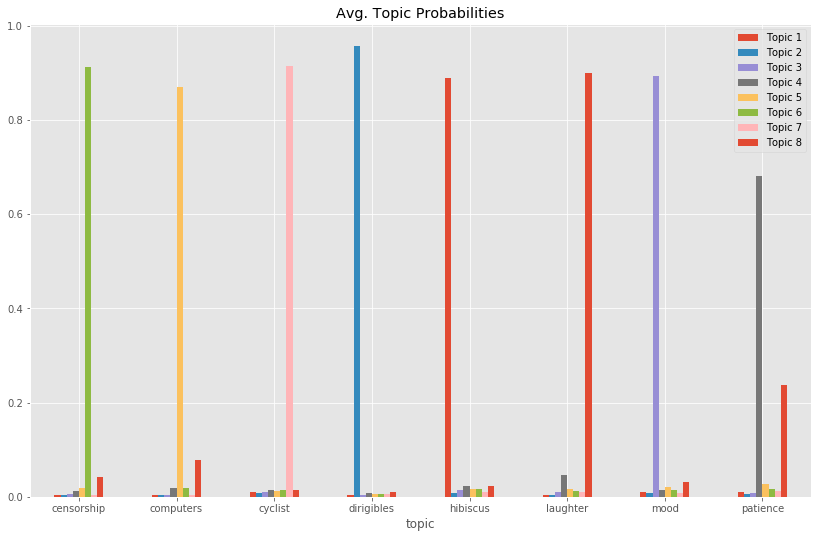

In [48]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities', rot=0);

,0
topic,
censorship,Topic 6
computers,Topic 5
cyclist,Topic 7
dirigibles,Topic 2
hibiscus,Topic 1
laughter,Topic 8
mood,Topic 3
patience,Topic 4


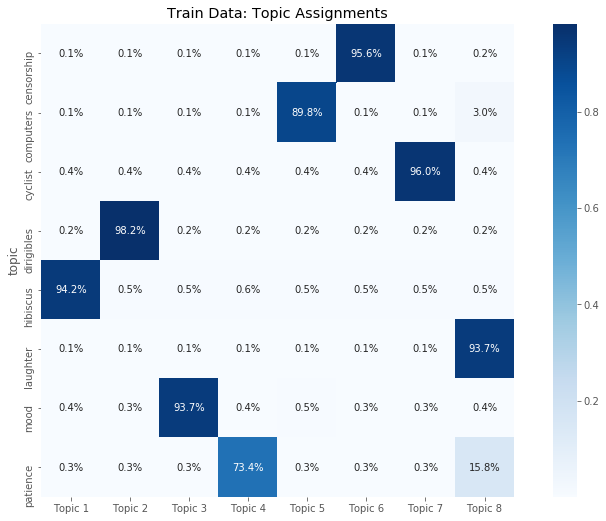

In [49]:
df = train_eval.groupby(level='topic').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

df = train_eval.idxmax(axis=1).reset_index().groupby('topic').agg(lambda x:x.value_counts().index[0])
df

### Evaluate Fit on Test Set 

In [50]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head(8)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
topic,,,,,,,,
dirigibles,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.00
censorship,0.00,0.00,0.02,0.00,0.00,0.92,0.02,0.03
cyclist,0.00,0.00,0.00,0.00,0.00,0.00,0.97,0.00
mood,0.00,0.00,0.87,0.06,0.06,0.00,0.00,0.00
laughter,0.00,0.00,0.00,0.00,0.17,0.23,0.00,0.59
hibiscus,0.89,0.02,0.02,0.02,0.02,0.02,0.02,0.02
computers,0.00,0.00,0.04,0.00,0.88,0.00,0.02,0.06
dirigibles,0.01,0.81,0.01,0.10,0.01,0.01,0.06,0.01


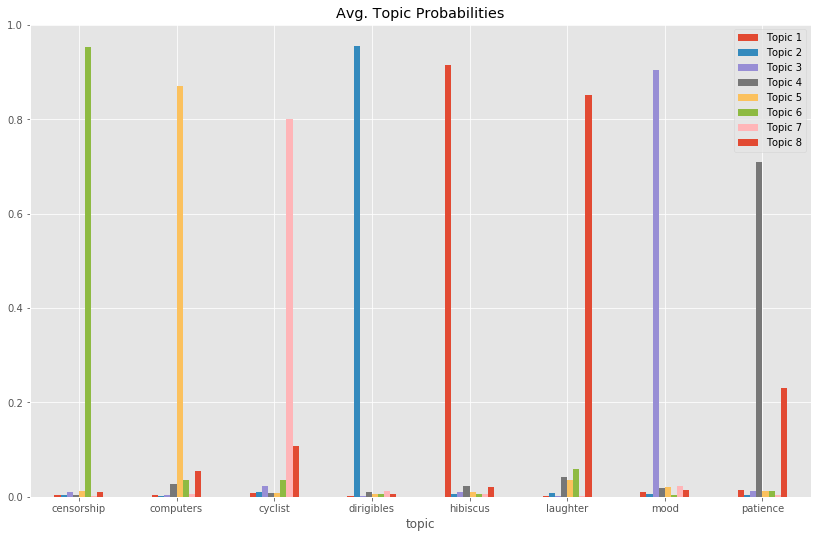

In [51]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities', rot=0);

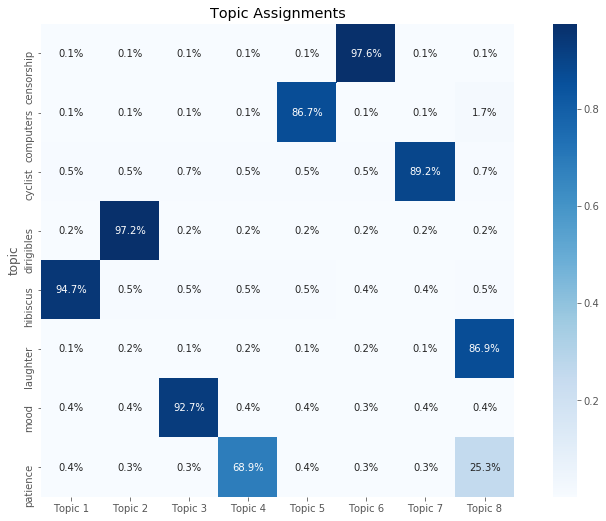

In [52]:
df = test_eval.groupby(level='topic').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)


# df = test_eval.groupby(level='topic').idxmax(
#     axis=1).reset_index(-1, drop=True)
# sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
#             .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

### Retrain until perplexity no longer decreases

In [53]:
lda_opt = LatentDirichletAllocation(n_components=8, 
                                    n_jobs=-1, 
                                    max_iter=500,
                                    learning_method='batch', 
                                    evaluate_every=5,
                                    verbose=1, 
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 471.7312
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 451.4673
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 449.1669
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 448.9369
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 448.8644


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=500,
             mean_change_tol=0.001, n_components=8, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [54]:
joblib.dump(lda_opt, 'lda_opt.pkl')

['lda_opt.pkl']

In [55]:
lda_opt = joblib.load('lda_opt.pkl')

In [56]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)

In [57]:
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

### Compare Train & Test Topic Assignments 

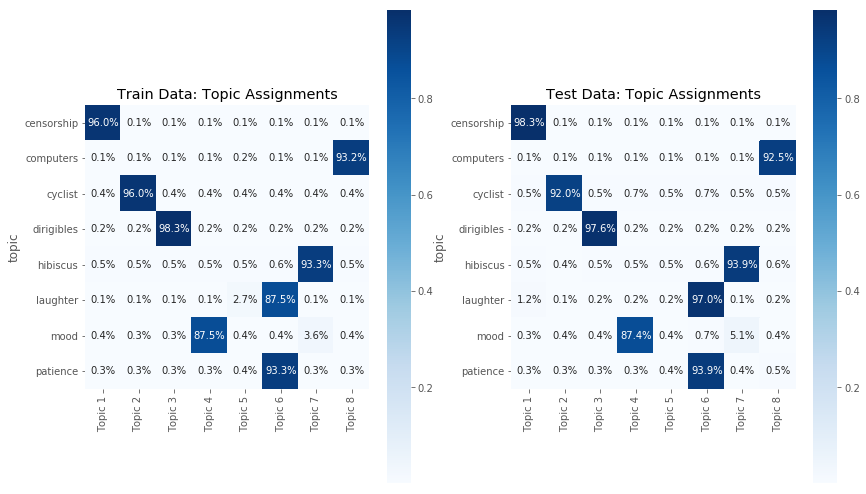

In [58]:
fig, axes = plt.subplots(ncols=2)
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').agg('median')
    sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]));

### Explore misclassified articles 

In [59]:
test_assignments = test_opt_eval.groupby(level=0).agg('mean')
print(test_assignments.head())
test_assignments = test_assignments.reset_index(-1, drop=False).reset_index()
# test_assignments['essay_id'] = test_docs.topic
# test_assignments['essay'] = test_docs.essay.values
# test_assignments.head()
test_assignments = test_opt_eval.idxmax(axis=1).groupby(level='topic').agg(lambda x:x.value_counts().index[0])
# test_assignments = test_assignments.reset_index(0, drop=True).to_frame('predicted').reset_index()
# test_assignments['heading'] = test_docs.heading.values
# test_assignments['article'] = test_docs.article.values
test_assignments.head(10)


            Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  \
topic                                                                       
censorship     0.96     0.00     0.00     0.00     0.00     0.01     0.00   
computers      0.03     0.00     0.00     0.00     0.04     0.03     0.00   
cyclist        0.04     0.80     0.01     0.02     0.01     0.10     0.01   
dirigibles     0.01     0.01     0.95     0.00     0.00     0.01     0.00   
hibiscus       0.01     0.01     0.01     0.01     0.01     0.04     0.90   

            Topic 8  
topic                
censorship     0.01  
computers      0.89  
cyclist        0.01  
dirigibles     0.01  
hibiscus       0.02  


topic
censorship    Topic 1
computers     Topic 8
cyclist       Topic 2
dirigibles    Topic 3
hibiscus      Topic 7
laughter      Topic 6
mood          Topic 4
patience      Topic 6
dtype: object

In [60]:
# misclassified = test_assignments[(test_assignments.topic == 'computers') & (
#     test_assignments.predicted == 'Topic 2')]
# misclassified.heading

In [61]:
# misclassified.essay.tolist()

### PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

#### Refit using all data

In [62]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.essay)

In [63]:
lda_all = LatentDirichletAllocation(n_components=8,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 406.4333
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 406.1959
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 406.1763


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=500, mean_change_tol=0.001,
             n_components=8, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [64]:
joblib.dump(lda_all, 'lda_all.pkl')

['lda_all.pkl']

In [65]:
lda_all = joblib.load('lda_all.pkl') 

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [66]:
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
2     -0.08  0.13       1        1 22.37
3     -0.09  0.10       2        1 21.57
4     -0.09  0.10       3        1 14.58
1      0.38  0.05       4        1 10.85
5     -0.10  0.07       5        1 10.40
6     -0.07 -0.20       6        1  8.03
0      0.06 -0.03       7        1  6.47
7     -0.02 -0.22       8        1  5.73, topic_info=     Category      Freq        Term     Total  loglift  logprob
term                                                           
354   Default 10,678.00   computers 10,678.00    30.00    30.00
222   Default  7,514.00    building  7,514.00    29.00    29.00
353   Default  9,375.00    computer  9,375.00    28.00    28.00
193   Default  8,131.00       books  8,131.00    27.00    27.00
432   Default  3,772.00     cyclist  3,772.00    26.00    26.00
1154  Default  4,067.00        mood  4,067.00    25.00    25.00
117   Default  5,498.00      author  5,498.00    24.00    24.00
1266  Default  5,282.00     parents  5,282.00    23.00    23.00
643   Default  6,314.00      family  6,314.00    22.00    22.00
503   Default  3,842.00  dirigibles  3,842.00    21.00    21.00
1694  Default  4,713.00       story  4,713.00    20.00    20.00
192   Default  5,851.00        book  5,851.00    19.00    19.00
563   Default  3,441.00      empire  3,441.00    18.00    18.00
1506  Default  2,645.00       saeng  2,645.00    17.00    17.00
1228  Default  4,906.00   offensive  4,906.00    16.00    16.00
1778  Default  2,623.00        test  2,623.00    15.00    15.00
1926  Default  2,821.00       water  2,821.00    14.00    14.00
1675  Default  3,838.00       state  3,838.00    13.00    13.00
1092  Default  2,969.00        mast  2,969.00    12.00    12.00
1555  Default  2,377.00     setting  2,377.00    11.00    11.00
1112  Default  2,493.00      memoir  2,493.00    10.00    10.00
1281  Default  2,983.00     patient  2,983.00     9.00     9.00
1290  Default 20,905.00      people 20,905.00     8.00     8.00
991   Default  2,491.00    laughter  2,491.00     7.00     7.00
1264  Default  2,990.00   paragraph  2,990.00     6.00     6.00
842   Default  1,941.00    hibiscus  1,941.00     5.00     5.00
1017  Default  3,997.00     library  3,997.00     4.00     4.00
221   Default  2,487.00    builders  2,487.00     3.00     3.00
858   Default  4,265.00        home  4,265.00     2.00     2.00
1158  Default  2,329.00     mooring  2,329.00     1.00     1.00
...       ...       ...         ...       ...      ...      ...
1327   Topic8    793.52       plant    811.06     2.84    -4.33
358    Topic8    215.07   concluded    219.94     2.84    -5.63
637    Topic8    163.89     failing    169.19     2.83    -5.91
1472   Topic8    542.65      return    563.35     2.82    -4.71
1137   Topic8     81.12      misses     84.59     2.82    -6.61
532    Topic8    157.83     drivers    166.20     2.81    -5.94
1592   Topic8    245.87    silently    261.89     2.80    -5.50
1328   Topic8    202.63      plants    216.99     2.79    -5.69
636    Topic8    445.99      failed    500.70     2.74    -4.91
641    Topic8    201.97    familiar    222.13     2.76    -5.70
1627   Topic8    338.04        snow    409.28     2.67    -5.18
1694   Topic8  2,879.55       story  4,713.13     2.37    -3.04
1264   Topic8  1,672.89   paragraph  2,990.89     2.28    -3.58
117    Topic8  2,368.88      author  5,498.73     2.02    -3.24
1271   Topic8    399.57        pass    554.91     2.53    -5.02
1191   Topic8  1,016.31         new  4,225.66     1.43    -4.08
858    Topic8    917.83        home  4,265.13     1.32    -4.18
1586   Topic8    568.03       shows  1,771.79     1.72    -4.66
1160   Topic8    397.47      mother  1,007.19     1.93    -5.02
335    Topic8    569.88        come  2,385.69     1.43    -4.66
1914   Topic8    344.39       wants    745.76     2.09    -5.16
1847   Topic8    386.51         try  1,293.81     1.65    -5.05
1022   Topic8    710.44    

### Topics as WordClouds

In [67]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)

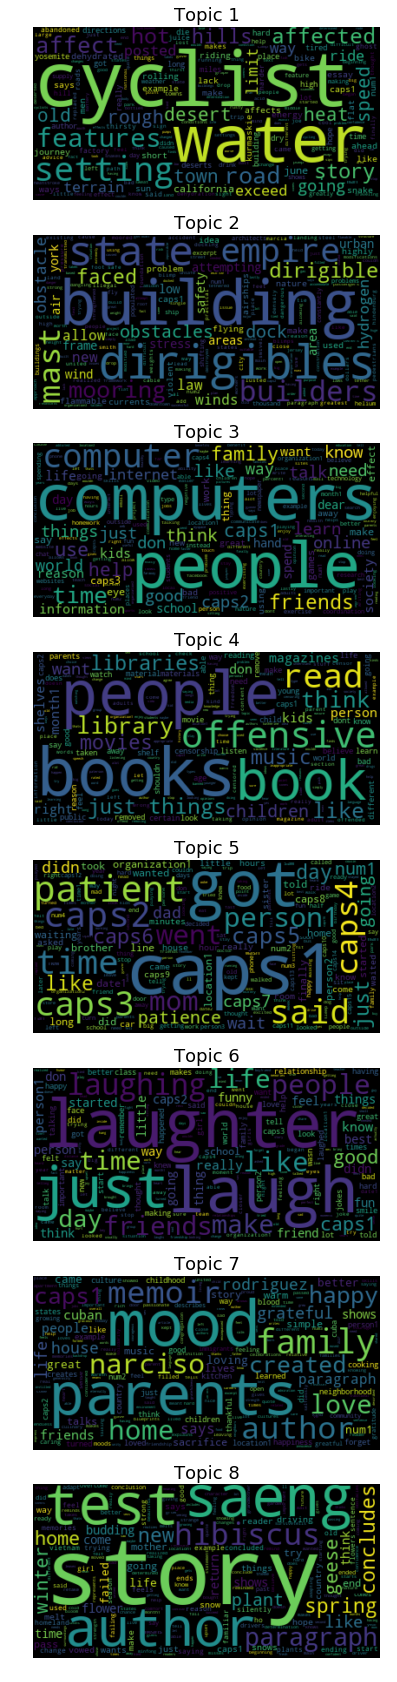

In [68]:
w = WordCloud()
fig, axes = plt.subplots(nrows=8, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Visualize topic-word assocations per document

In [69]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=docs.topic)

In [70]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}

In [92]:
dtm_['article'] = docs.essay.values
# dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.05).all(1)]
sample

AttributeError: 'list' object has no attribute 'essay'

In [72]:
colored_text = []
for word in sample.iloc[0, 8].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)
#    ®
print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 8], '\n')
text = ' '.join(colored_text)
print(text)

IndexError: single positional indexer is out-of-bounds

## LDA with gensim

### Using `CountVectorizer` Input

In [73]:
max_df = .2
min_df = 3
max_features = 2000

# used by sklearn: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True).tolist()

In [74]:
vectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words='english', 
                             max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.essay)
test_dtm = vectorizer.transform(test_docs.essay)

In [75]:
train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)

id2word = pd.Series(vectorizer.get_feature_names()).to_dict()

### Train Model & Review Results

In [76]:
lda_gensim = LdaModel(corpus=train_corpus,
                          num_topics=8,
                          id2word=id2word)

In [77]:
topics = lda_gensim.print_topics()
topics[0]

(0,
 '0.026*"laughter" + 0.019*"friends" + 0.018*"laugh" + 0.011*"better" + 0.010*"mood" + 0.009*"love" + 0.008*"makes" + 0.008*"parents" + 0.008*"person" + 0.008*"happy"')

### Evaluate Topic Coherence

Topic Coherence measures whether the words in a topic tend to co-occur together. 

- It adds up a score for each distinct pair of top ranked words. 
- The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word.

Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often.

In [78]:
coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')

  Topic 1             Topic 2            Topic 3            Topic 4          Topic 5            Topic 6           Topic 7           Topic 8         
     prob        term    prob       term    prob       term    prob     term    prob       term    prob      term    prob      term    prob     term
0   6.42%    building   4.09%      books   5.42%  computers   1.54%  patient   5.65%      saeng   2.59%  laughter  10.85%  patience   3.18%  cyclist
1   3.45%  dirigibles   2.78%       book   4.73%   computer   1.54%      got   5.25%       test   1.88%   friends   2.31%      wait   3.02%     mood
2   3.08%       state   2.26%  offensive   1.40%    friends   1.42%    caps3   3.92%   hibiscus   1.84%     laugh   1.48%   waiting   2.45%  parents
3   3.03%      empire   2.00%    library   1.26%        use   1.33%     said   3.22%  paragraph   1.06%    better   1.21%   patient   2.00%   memoir
4   2.67%        mast   1.99%       read   1.22%       help   1.29%  person1   2.13%     spring   0.97%   

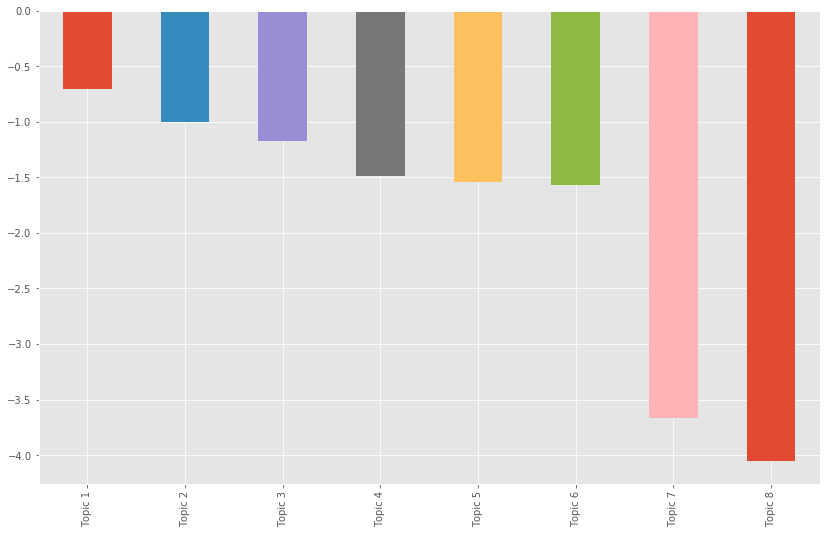

In [79]:
topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
print(topic_words.head())
pd.Series(topic_coherence, index=topic_labels).plot.bar();

### Using `gensim` `Dictionary` 

In [80]:
docs = [d.split() for d in train_docs.essay.tolist()]
docs = [[t for t in doc if t not in stop_words] for doc in docs]

In [81]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

In [82]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [83]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 12876


In [84]:
num_topics = 8
chunksize = 500
passes = 20
iterations = 400
eval_every = None # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [85]:
%%time
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes, 
                 eval_every=eval_every)

Wall time: 1min 19s


In [86]:
model.show_topics()

[(0,
  '0.041*"got" + 0.029*"went" + 0.027*"said" + 0.026*"patient" + 0.023*"mom" + 0.020*"We" + 0.020*"@PERSON1" + 0.016*"started" + 0.015*"@NUM1" + 0.014*"So"'),
 (1,
  '0.044*"cyclist" + 0.032*"setting" + 0.027*"memoir" + 0.026*"water" + 0.021*"Narciso" + 0.018*"He" + 0.018*"features" + 0.016*"grateful" + 0.014*"affect" + 0.012*"affected"'),
 (2,
  '0.055*"mood" + 0.051*"parents" + 0.032*"family" + 0.023*"love" + 0.020*"created" + 0.018*"happy" + 0.016*"house" + 0.014*"life" + 0.012*"paragraph" + 0.011*"shows"'),
 (3,
  '0.044*"computers" + 0.016*"use" + 0.015*"help" + 0.015*"Computers" + 0.012*"family" + 0.012*"learn" + 0.011*"talk" + 0.010*"computer." + 0.010*"friends" + 0.010*"need"'),
 (4,
  '0.047*"story" + 0.035*"Saeng" + 0.031*"test" + 0.024*"paragraph" + 0.023*"hibiscus" + 0.020*"new" + 0.017*"concludes" + 0.017*"She" + 0.014*"geese" + 0.012*"shows"'),
 (5,
  '0.032*"dirigibles" + 0.031*"Empire" + 0.030*"building" + 0.030*"State" + 0.023*"builders" + 0.020*"faced" + 0.020*"m

### Evaluating Topic Assignments on the Test Set

In [87]:
docs_test = [d.split() for d in test_docs.essay.tolist()]
docs_test = [[t for t in doc if t not in stop_words] for doc in docs_test]

test_dictionary = Dictionary(docs_test)
test_dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)
test_corpus = [dictionary.doc2bow(doc) for doc in docs_test]

In [88]:
gamma, _ = model.inference(test_corpus)
topic_scores = pd.DataFrame(gamma)
topic_scores.head(10)

,0,1,2,3,4,5,6,7
0,0.10,0.10,0.15,0.08,0.12,50.74,0.08,5.63
1,0.10,0.11,0.15,0.08,2.83,1.28,45.28,9.18
2,0.10,31.98,2.27,0.08,0.12,0.08,0.08,0.31
3,0.10,9.21,37.79,0.08,4.65,0.08,0.08,9.02
4,2.14,0.10,0.15,10.94,0.12,0.08,8.17,39.31
5,0.10,0.10,0.15,0.08,7.05,0.08,0.08,0.37
6,0.10,8.55,3.62,102.59,0.12,0.08,10.67,48.28
7,3.97,0.10,0.15,0.08,0.12,15.19,0.08,0.31
8,0.10,1.52,0.15,43.03,3.96,0.08,1.92,9.25
9,0.89,0.10,3.78,0.08,32.90,0.08,0.08,4.08


In [89]:
topic_probabilities = topic_scores.div(topic_scores.sum(axis=1), axis=0)
topic_probabilities.head()

,0,1,2,3,4,5,6,7
0,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.10
1,0.00,0.00,0.00,0.00,0.05,0.02,0.77,0.16
2,0.00,0.91,0.06,0.00,0.00,0.00,0.00,0.01
3,0.00,0.15,0.62,0.00,0.08,0.00,0.00,0.15
4,0.04,0.00,0.00,0.18,0.00,0.00,0.13,0.64


In [90]:
topic_probabilities.idxmax(axis=1).head(10)

0    5
1    6
2    1
3    2
4    7
5    4
6    3
7    5
8    3
9    4
dtype: int64

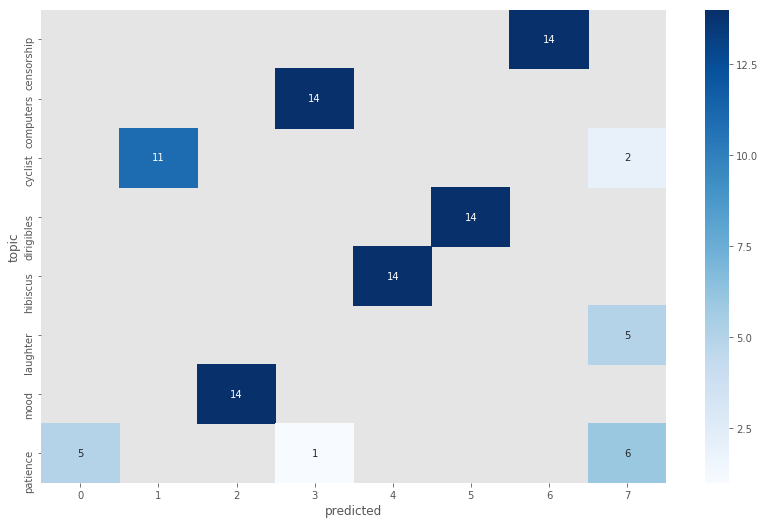

In [91]:
predictions = test_docs.topic.to_frame('topic').assign(predicted=topic_probabilities.idxmax(axis=1).values)
heatmap_data = predictions.groupby('topic').predicted.value_counts().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='Blues');